In [1]:
%matplotlib inline
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [11]:
# First understand the database and the tables by using the inspector
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [12]:
#Next use inspector do get the column names and data types for each table.
#Start with the table "measurements"
columns_1 = inspector.get_columns('measurement')
for c in columns_1:
    print (c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
#Do the same for table "station"
columns_2 = inspector.get_columns('station')
for c in columns_2:
    print (c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
# Determine the last date in the date column
# Need to perform a session.query
# Using session.query returns date as text
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(last_date)

2017-08-23


In [15]:
# Determine the data type of last_date to confirm that it is a String
type(last_date)

str

In [16]:
#Convert last_date from string to Date type
# Use the strptime method of datetime to convert the date from String to Datetime showing YYYY-MM-DD
# https://stackoverflow.com/questions/466345/converting-string-into-datetime

from datetime import datetime, timedelta

end = datetime.strptime(last_date, '%Y-%m-%d')


print(end)
type(end)

2017-08-23 00:00:00


datetime.datetime

In [17]:
#Determine date 12 months before the last_date by using timedelta
# http://www.pressthered.com/adding_dates_and_times_in_python/ 
# using 366 because I want to capture 2016-08-23 as the first day in the query result
# when I used 365 it gave me 2016-08-24 as the first day in the query results
#from datetime import datetime, timedelta - already done in cell aboe

twelve_months_prior = end - timedelta(days=366)
print(twelve_months_prior)


2016-08-22 00:00:00


In [18]:
#Retrieve last 12 months of precipitation data - 8/23/2016 to 8/23/2017
# Extract using session.query
# https://appdividend.com/2019/01/26/pandas-set-index-example-python-set_index-tutorial/
# Extracted the "daily" precipitation measured at individual stations for a given day

daily_indiv_station_prcp_results = session.query(Measurement.prcp, Measurement.date).\
          filter(Measurement.date.between(twelve_months_prior, end))

#Define two lists to store the daily prcp and date values

daily_indiv_station_prcp=[]
date=[]

for row in daily_indiv_station_prcp_results:
    daily_indiv_station_prcp.append(row[0])
    date.append(row[1])

#Define a pandas dataframe to store the values in order to be able to plot

daily_indiv_station_prcp_df = pd.DataFrame({"Date":date,"Daily Precipitation Per Weather Station":daily_indiv_station_prcp})
daily_indiv_station_prcp_df.set_index("Date",inplace=True)
daily_indiv_station_prcp_df.head(5)
              

,Daily Precipitation Per Weather Station
Date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [19]:
#Use Pandas to calculate the summary statistics for the daily precipitation data

daily_indiv_station_prcp_df.describe(include = 'all')

,Daily Precipitation Per Weather Station
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


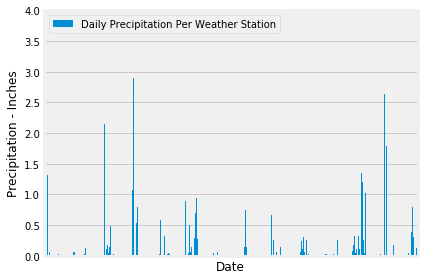

In [20]:
#Plot the barchart showing precipitation versus date
#plt.figure(1)

precip_chart = daily_indiv_station_prcp_df.plot(kind="bar")

#Set the x-label and y-label
precip_chart.plot(figsize=(20,5))
precip_chart.set_xlabel("Date")
precip_chart.set_ylabel("Precipitation - Inches")

# removes values on x-axis
plt.xticks([])
plt.ylim(0,4)
plt.tight_layout()
plt.show()


In [21]:
# The barchart above - in my opinion - does not have much utility because techncally there are 2021 bars 
# denoting rainfall at multiple stations for each day

# Therefore, I performed a query such that it returns the average rainfall of all stations, for a given day
# Results as well as the bar chart are shown below

In [22]:
#Retrieve last 12 months of "Average" precipitation data - 8/23/2016 to 8/23/2017
# Extract using session.query
# https://appdividend.com/2019/01/26/pandas-set-index-example-python-set_index-tutorial/
# Extracted the "average" precipitation measured by all stations for a given day

avg_prcp_results=session.query(func.avg(Measurement.prcp), Measurement.date).group_by(Measurement.date).\
          filter(Measurement.date.between(twelve_months_prior, end)).all()

#Define two lists to store the average daily prcp and date
avg_prcp=[]
meas_date=[]

for row in avg_prcp_results:
    avg_prcp.append(row[0])
    meas_date.append(row[1])

#Define a pandas dataframe to store the values in order to be able to plot

avg_prcp_df = pd.DataFrame({"Date":meas_date,"Avg. Daily Precipitation":avg_prcp})
avg_prcp_df.set_index("Date",inplace=True)
avg_prcp_df.head(5)

,Avg. Daily Precipitation
Date,
2016-08-23,0.451667
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000


In [23]:
#Use Pandas to calculate the summary statistics for the average precipitation data

avg_prcp_df.describe(include = 'all')

,Avg. Daily Precipitation
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


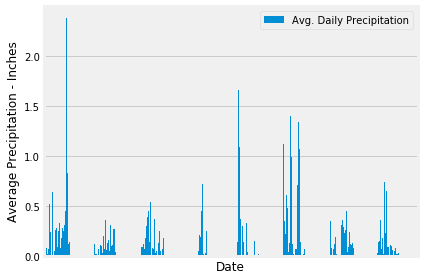

In [24]:
#Plot the barchart showing precipitation versus date
#plt.figure(1)

precip_chart = avg_prcp_df.plot(kind="bar")

#Set the x-label and y-label
precip_chart.set_xlabel("Date")
precip_chart.set_ylabel("Average Precipitation - Inches")

# removes values on x-axis
plt.xticks([])
plt.tight_layout()
plt.show()



In [25]:
# Design a query to show how many stations are available in this dataset?
# Count the unique number of stations in measurements table
# https://wiki.workassis.com/sum-avg-count-max-group_by-distinct-sqlalchemy/
    
from sqlalchemy import distinct

no_unique_stations = session.query(func.count(distinct(Measurement.station))).scalar()
print(no_unique_stations)                              


9


In [26]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

from sqlalchemy import desc

session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).all()



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [27]:
#From the above list, 'USC00519281" is the most active station'

In [28]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?


session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                    filter(Measurement.station == "USC00519281").all()


[(54.0, 85.0, 71.66378066378067)]

In [29]:
# Choose the station with the highest number of temperature observations.

session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
       order_by(desc(func.count(Measurement.tobs))).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [30]:
# From the above cell, the station with the highest number of temperature observations is 'USC00519281'
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_results=session.query(Measurement.tobs).filter(Measurement.station == "USC00519281").\
          filter(Measurement.date.between(twelve_months_prior, end))

# Define a list to store the temperature values

temps = []

for row in temp_results:
    temps.append(row[0])

#Define a pandas dataframe to store the values in order to be able to plot

temp_df = pd.DataFrame({"Temperature":temps})

temp_df.head(5)



,Temperature
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


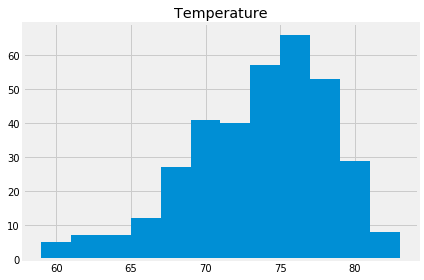

In [31]:
# Draw the histogram

temp_chart = temp_df.hist(bins=12)
plt.tight_layout()
plt.show()


In [32]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-23', '2012-03-05'))

[(62.0, 70.01063829787235, 77.0)]


In [33]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# Assume my vacation dates are 2017-04-16 to 2017-05-01 (celebrating the filing of the tax return)

# function usage for my trip from 2017-04-16 to 2017-05-01
vacation_values = calc_temps('2017-04-16', '2017-05-01')
print(vacation_values)

[(58.0, 72.78217821782178, 83.0)]


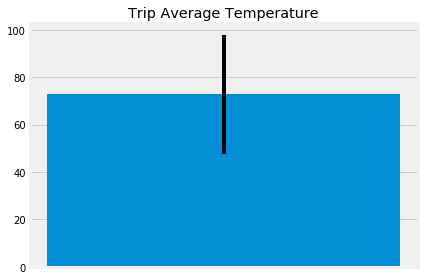

In [34]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# https://pythonforundergradengineers.com/python-matplotlib-error-bars.html

tmin,tavg,tmax = vacation_values[0]

#print(tmin)
#print(tavg)
#print(tmax)

yerror = tmax-tmin

#print(yerror)

#error_chart = plt.bar(1, tavg, yerr=yerror)
#error_chart.show()

# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.errorbar.html
plt.bar(1,tavg)
#plt.subplots(figsize=plt.figaspect(2.))
plt.errorbar(1, tavg, yerr=yerror, color = "black")
#plt.subplots(figsize=plt.figaspect(2.))
plt.title("Trip Average Temperature")
plt.xticks([])
plt.tight_layout()
plt.show()

# The following code was given to me by Bowen but this also has the same problem.
# It also shows an error message as follows when run:

# C:\Users\rames\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Matplotlib is 
# currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.

# Therefore, I used the original code given above.

# # import dependencies
# import matplotlib.pyplot as plt

# # defines variables to be used in plot
# #tmin, tavg, tmax = [62.0, 68.36585365853658, 74.0]
# tmin, tavg, tmax = vacation_values[0]
# yerr = tmax - tmin
# xpos = 1

# # builds and shows plot
# fig, ax = plt.subplots(figsize=plt.figaspect(2.))
# ax.bar(xpos, tavg)
# ax.errorbar(xpos, tavg, yerr=yerr, color="black")
# ax.set(xticks=range(xpos), xticklabels="a", title="Trip Avg Temp", ylabel="Temp (F)")
# fig.tight_layout()
# fig.show()




In [35]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# I have now done this for the entire year
# The start date is 2016-08-23 and end date is 2017-08-23

# Based on the way the function calc_temp is defined we have to hard code the dates in the function call
# function usage for my trip from 2017-04-16 to 2017-05-01
twelve_month_values = calc_temps('2016-08-23', '2017-08-23')

print(twelve_month_values)

[(58.0, 74.59058295964125, 87.0)]


In [36]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# Per Michael use the vacation dates you have used above

trip_begin = datetime.strptime('2017-04-16', '%Y-%m-%d')
trip_end = datetime.strptime('2017-05-01', '%Y-%m-%d')

results =  session.query(func.sum(Measurement.prcp), Measurement.date, Measurement.station, Station.latitude, Station.longitude,Station.elevation).\
          join(Station,Measurement.station == Station.station).filter(Measurement.station==Station.station).\
          filter(Measurement.date.between(trip_begin,trip_end)).group_by(Measurement.station).order_by(desc(func.sum(Measurement.prcp))).all()

#print(result)

# Define lists to store all required values


total_station_rainfall = []
measurement_begin_date = []
measurement_end_date = []
station_name = []
station_latitude = []
station_longitude = []
station_elevation = []

for row in results:
    total_station_rainfall.append(row[0])
    measurement_begin_date.append(trip_begin)
    measurement_end_date.append(row[1])
    station_name.append(row[2])
    station_latitude.append(row[3])
    station_longitude.append(row[4])
    station_elevation.append(row[5])
    
#Define a pandas dataframe to store the values in order for display

rainfall_df = pd.DataFrame({"Station":station_name, "Measurement Begin Date":measurement_begin_date, "Measurement End Date":measurement_end_date,\
                            "Latitude":station_latitude,"Longitude":station_longitude,"Elevation":station_elevation, "Total Rainfall":total_station_rainfall})


rainfall_df


,Station,Measurement Begin Date,Measurement End Date,Latitude,Longitude,Elevation,Total Rainfall
0,USC00519523,2017-04-16,2017-04-17,21.33556,-157.71139,19.5,10.80
1,USC00519281,2017-04-16,2017-04-17,21.45167,-157.84889,32.9,9.04
2,USC00516128,2017-04-16,2017-04-17,21.33310,-157.80250,152.4,8.18
3,USC00513117,2017-04-16,2017-04-17,21.42340,-157.80150,14.6,7.36
4,USC00514830,2017-04-16,2017-04-17,21.52130,-157.83740,7.0,4.27
5,USC00519397,2017-04-16,2017-04-17,21.27160,-157.81680,3.0,1.94
6,USC00517948,2017-04-16,2017-04-17,21.39340,-157.97510,11.9,0.00


## Optional Challenge Assignment

In [37]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [38]:
# calculate the daily normals for your trip

# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

trip_dates = ["04-16","04-17","04-18","04-19","04-20","04-21","04-22","04-23","04-24","04-25","04-26","04-27","04-28",\
              "04-29","04-30","05-01"]
trip_daily_normals = []

for date in trip_dates:
    trip_daily_normals.append(daily_normals(date))
    
#print(trip_daily_normals)

# Split the tuples into separate lists
# https://stackoverflow.com/questions/21867303/how-to-split-a-list-of-2-tuples-into-two-lists

#trip_daily_min,trip_daily_avg,trip_daily_max = map(list, zip(*trip_daily_normals))

def get_list(tuples):
    list1 = []
    list2 = []
    list3 = []
    for i in tuples:
        list1.append(i[0][0])
        list2.append(i[0][1])
        list3.append(i[0][2])
    return list1, list2, list3

#Make the function call to get the daily normals for each of the trip dates

trip_daily_min, trip_daily_avg, trip_daily_max = get_list(trip_daily_normals)



In [39]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

#Define a pandas dataframe to store the values in order for display

#Define a pandas dataframe to store the values in order for display

trip_normals_df = pd.DataFrame({"Trip Date":trip_dates,"Daily Normal Min":trip_daily_min,"Daily Normal Avg":trip_daily_avg,"Daily Normal Max":trip_daily_max})
trip_normals_df.set_index("Trip Date",inplace=True)
trip_normals_df.head(5)


,Daily Normal Min,Daily Normal Avg,Daily Normal Max
Trip Date,,,
04-16,62.0,71.553571,81.0
04-17,65.0,71.931034,77.0
04-18,67.0,72.491525,77.0
04-19,65.0,72.421053,83.0
04-20,64.0,72.736842,80.0


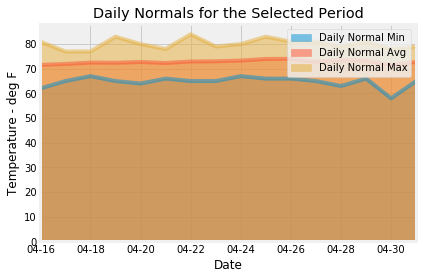

In [40]:
# Plot the daily normals as an area plot with `stacked=False`
# raReference: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.area.html

ax = trip_normals_df.plot.area(stacked=False)

plt.legend(loc='upper right')
plt.title("Daily Normals for the Selected Period")
plt.xlabel("Date")
plt.ylabel("Temperature - deg F")
plt.show()
